In [12]:
!pip install seaborn lifelines


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from lifelines import KaplanMeierFitter, CoxPHFitter


In [14]:
# Final corrected run with robust stratify handling
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
)
import joblib
import matplotlib.pyplot as plt

DATA_PATH = "/content/patient_data.csv"
OUTPUT_DIR = "/mnt/data/liver_monitoring_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv("/content/patient_data.csv")

possible_label_names = ['diagnosis','target','label','cancer','has_cancer','liver_disease','liver_cancer','Outcome','Class','y','result']
label_col = None
for name in possible_label_names:
    if name in df.columns:
        label_col = name
        break
if label_col is None:
    for col in df.columns:
        uniques = df[col].dropna().unique()
        if df[col].dtype.kind in 'biufc' and len(uniques) <= 3:
            label_col = col
            break
        if df[col].dtype == object and len(uniques) <= 3:
            label_col = col
            break
if label_col is None:
    label_col = df.columns[-1]

y_raw = df[label_col].copy()
X_raw = df.drop(columns=[label_col])

def normalize_label(series):
    s = series.copy()
    if s.dtype == object:
        s = s.str.strip().str.lower()
        mapping = {'m':1,'malignant':1,'yes':1,'positive':1,'present':1}
        mapping0 = {'b':0,'benign':0,'no':0,'negative':0,'absent':0}
        s = s.replace(mapping)
        s = s.replace(mapping0)
        try:
            return pd.to_numeric(s, errors='ignore')
        except:
            return s
    return s

y = normalize_label(y_raw)
if y.dtype == object:
    if y.nunique() <= 5:
        y = pd.Series(pd.factorize(y)[0])
    else:
        try:
            y = pd.Series(pd.to_numeric(y))
        except:
            y = pd.Series(pd.factorize(y)[0])
else:
    y = pd.Series(pd.to_numeric(y, errors='coerce'))

# Ensure labels are non-negative integers for stratify checks
y_check = y.copy()
if not np.issubdtype(y_check.dtype, np.integer):
    try:
        y_check = y_check.astype(int)
    except:
        y_check = pd.Series(pd.factorize(y_check)[0])

mask_valid = ~pd.isna(y)
if mask_valid.sum() < len(y):
    X_raw = X_raw.loc[mask_valid.values].reset_index(drop=True)
    y = y.loc[mask_valid].reset_index(drop=True)
else:
    X_raw = X_raw.reset_index(drop=True)
    y = y.reset_index(drop=True)

numeric_cols = X_raw.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object','category','bool']).columns.tolist()
if len(numeric_cols)==0:
    for col in X_raw.columns:
        try:
            X_raw[col] = pd.to_numeric(X_raw[col])
            numeric_cols.append(col)
        except:
            if col not in cat_cols:
                cat_cols.append(col)

# decide stratify safely
stratify = None
try:
    counts = np.bincount(y.astype(int))
    if len(counts) > 1 and counts.min() > 1:
        stratify = y
except Exception:
    stratify = None

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=stratify
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

models = {
    'logistic': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) if len(np.unique(y))>1 else None
    if cv is not None:
        try:
            scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', error_score='raise')
            results[name] = {'cv_accuracy_mean': float(np.nanmean(scores)), 'cv_accuracy_std': float(np.nanstd(scores))}
        except Exception as e:
            results[name] = {'cv_accuracy_mean': None, 'cv_accuracy_std': None}
            print(f"Cross-val failed for {name}: {e}")
    else:
        results[name] = {'cv_accuracy_mean': None, 'cv_accuracy_std': None}
    print(f"\n{name} CV accuracy mean/std: {results[name]['cv_accuracy_mean']}/{results[name]['cv_accuracy_std']}")

best_name = max(results.keys(), key=lambda k: (results[k]['cv_accuracy_mean'] if results[k]['cv_accuracy_mean'] is not None else -1))
best_model = Pipeline(steps=[('preprocessor', preprocessor), ('clf', models[best_name])])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test) if hasattr(best_model.named_steps['clf'], "predict_proba") else None

print(f"\nSelected best model: {best_name}")
print("\nTest set classification report:")
print(classification_report(y_test, y_pred))

if y_proba is not None and len(np.unique(y)) == 2:
    try:
        auc = roc_auc_score(y_test, y_proba[:,1])
        print(f"Test ROC AUC: {auc:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
        plt.figure()
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve (test set)")
        roc_path = os.path.join(OUTPUT_DIR, "roc_curve.png")
        plt.savefig(roc_path)
        plt.close()
        print(f"Saved ROC curve to {roc_path}")
    except Exception as e:
        print("ROC AUC or curve failed:", e)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

model_path = os.path.join(OUTPUT_DIR, "best_model_pipeline.joblib")
joblib.dump(best_model, model_path)
print(f"\nSaved trained pipeline to {model_path}")

report = {
    'dataset_shape': df.shape,
    'label_column': label_col,
    'label_distribution': y.value_counts().to_dict(),
    'numeric_columns': numeric_cols,
    'categorical_columns': cat_cols,
    'cv_results': results,
    'selected_model': best_name
}
report_path = os.path.join(OUTPUT_DIR, "run_report.json")
import json
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)
print(f"Saved run report to {report_path}")

try:
    preprocessor.fit(X_train)
    num_names = numeric_cols
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot'] if cat_cols else None
    cat_names = []
    if ohe is not None and hasattr(ohe, 'get_feature_names_out'):
        cat_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names = num_names + cat_names
    feat_path = os.path.join(OUTPUT_DIR, "processed_feature_names.txt")
    with open(feat_path, 'w') as f:
        f.write("\n".join(feature_names))
    print(f"Saved processed feature names to {feat_path}")
except Exception as e:
    print("Could not extract processed feature names:", e)

print("\nAll done. Artifacts are saved under:", OUTPUT_DIR)

cv_summary = pd.DataFrame([
    {'model': k, 'cv_accuracy_mean': results[k]['cv_accuracy_mean'], 'cv_accuracy_std': results[k]['cv_accuracy_std']}
    for k in results
])
display(cv_summary)

cm_df = pd.DataFrame(cm, index=["true_"+str(i) for i in range(cm.shape[0])], columns=["pred_"+str(i) for i in range(cm.shape[1])])
display(cm_df)

print("\nDownloadable files (saved on the notebook filesystem):")
for fname in os.listdir(OUTPUT_DIR):
    print("-", os.path.join(OUTPUT_DIR, fname))

/tmp/ipython-input-2798861505.py:54: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(s, errors='ignore')



logistic CV accuracy mean/std: 0.8303030303030303/0.026601370555389102

random_forest CV accuracy mean/std: 0.7264069264069264/0.03185864847268242

Selected best model: logistic

Test set classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.86      0.93      0.89       167
           1       0.89      0.81      0.85       120

    accuracy                           0.87       289
   macro avg       0.58      0.58      0.58       289
weighted avg       0.87      0.87      0.87       289

Confusion matrix:
[[  0   2   0]
 [  0 155  12]
 [  0  23  97]]

Saved trained pipeline to /mnt/data/liver_monitoring_outputs/best_model_pipeline.joblib
Saved run report to /mnt/data/liver_monitoring_outputs/run_report.json
Saved processed feature names to /mnt/data/liver_monitoring_outputs/processed_feature_names.txt

All done. Artifacts are saved under: /mnt/data/liver_monitoring_outputs


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,cv_accuracy_mean,cv_accuracy_std
0,logistic,0.830303,0.026601
1,random_forest,0.726407,0.031859


,pred_0,pred_1,pred_2
true_0,0,2,0
true_1,0,155,12
true_2,0,23,97



Downloadable files (saved on the notebook filesystem):
- /mnt/data/liver_monitoring_outputs/dataset_description.csv
- /mnt/data/liver_monitoring_outputs/processed_feature_names.txt
- /mnt/data/liver_monitoring_outputs/run_report.json
- /mnt/data/liver_monitoring_outputs/best_model_pipeline.joblib


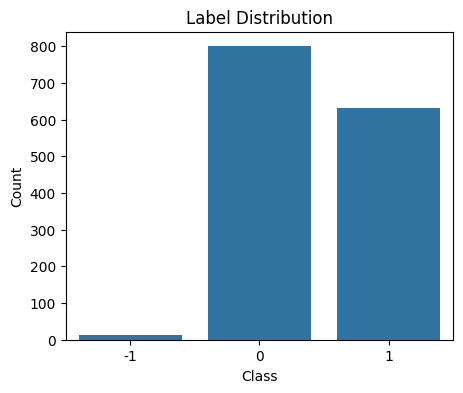

In [15]:
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


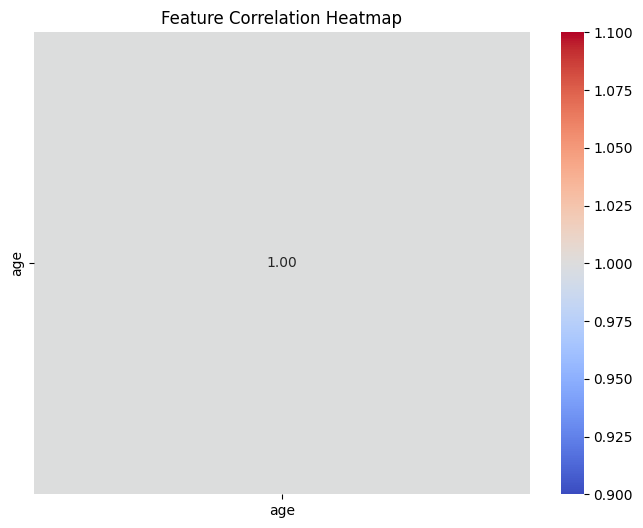

In [16]:
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


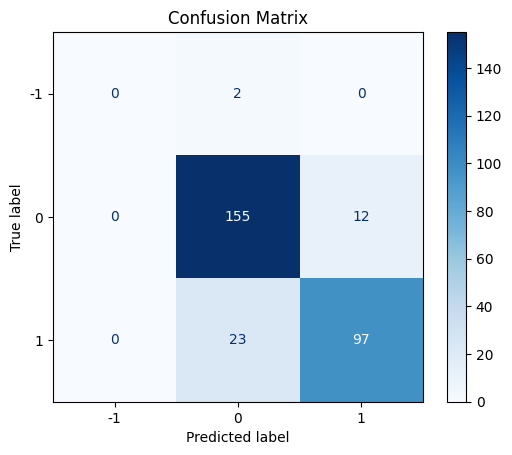

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import precision_recall_curve, auc

if y_proba is not None and len(np.unique(y)) == 2:
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:,1])
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, marker=".")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
    plt.show()


/tmp/ipython-input-3346328756.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df.values, y=coef_df.index, palette="magma")


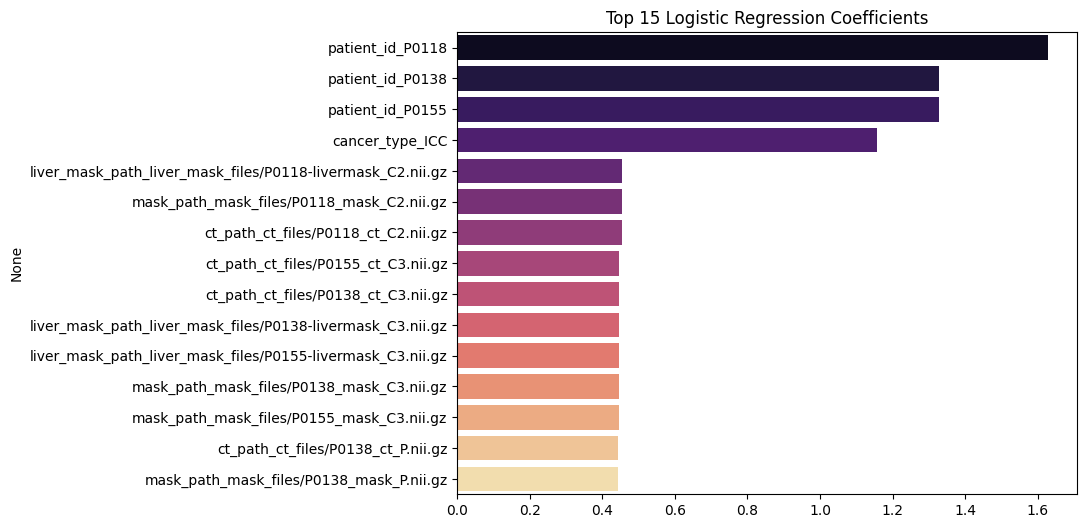

In [19]:
if best_name == "random_forest":
    importances = best_model.named_steps['clf'].feature_importances_
    feature_names = open(os.path.join(OUTPUT_DIR, "processed_feature_names.txt")).read().splitlines()
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.show()

elif best_name == "logistic":
    coefs = best_model.named_steps['clf'].coef_[0]
    feature_names = open(os.path.join(OUTPUT_DIR, "processed_feature_names.txt")).read().splitlines()
    coef_df = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)[:15]

    plt.figure(figsize=(8,6))
    sns.barplot(x=coef_df.values, y=coef_df.index, palette="magma")
    plt.title("Top 15 Logistic Regression Coefficients")
    plt.show()


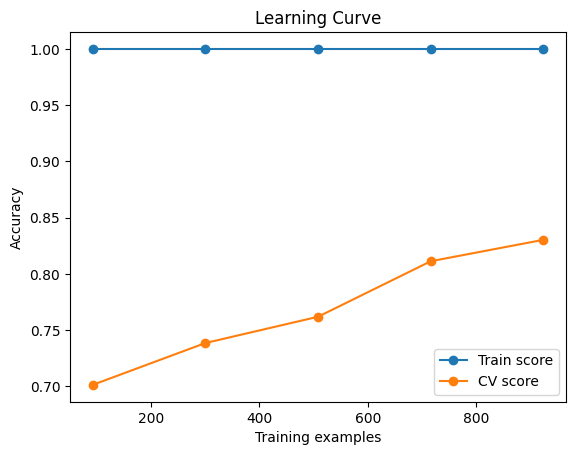

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="CV score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [22]:
# Extract the fitted preprocessor from the pipeline
preprocessor_fitted = best_model.named_steps['preprocessor']

# Transform the whole dataset
X_processed = preprocessor_fitted.transform(X_raw)

# Convert to dense if sparse (OneHotEncoder creates sparse matrix)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()


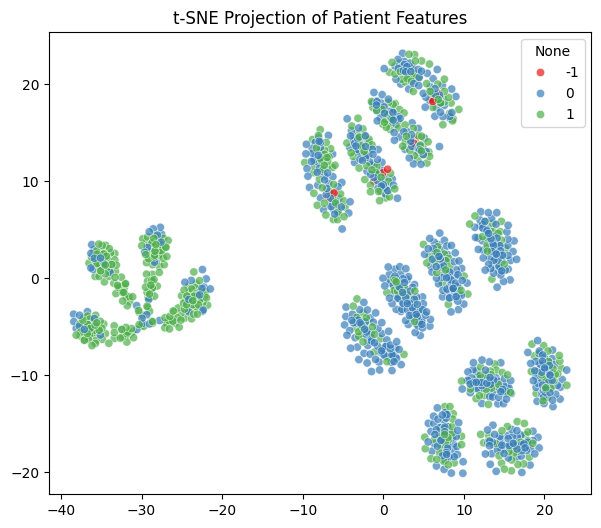

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_processed)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="Set1", alpha=0.7)
plt.title("t-SNE Projection of Patient Features")
plt.show()


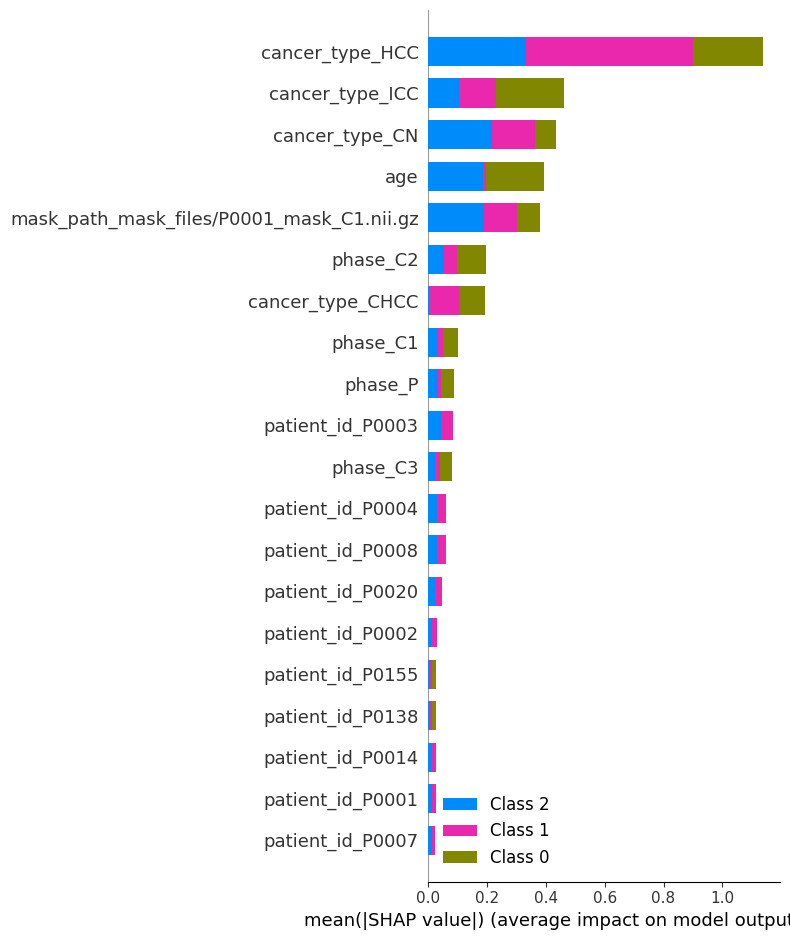

In [31]:
import shap
explainer = shap.Explainer(best_model.named_steps["clf"], X_processed)
shap_values = explainer(X_processed[:100])  # sample for speed

shap.summary_plot(shap_values, X_processed, feature_names=feature_names)
